# Quick overview

## Project Data Structure and Techniques

This project targets a generic Linux environment. All artifacts live inside a configurable workspace root (`XOUNDS_WORKSPACE`, default `./xounds_workspace`). The main directories are:

- `BASE_DIR/audio_inputs/consent`: Contains the raw audio files uploaded for the project.
- `BASE_DIR/audio_inputs/training`: Stores audio files allocated for training after splitting.
- `BASE_DIR/audio_inputs/evaluation`: Stores validation/evaluation audio files.
- `BASE_DIR/processing_outputs`: Holds intermediate artifacts such as embeddings and preprocessed audio.
- `BASE_DIR/model_output`: Stores trained or fine-tuned model checkpoints.
- `BASE_DIR/generated_audio`: Receives text-to-speech outputs generated for consent prompts.

You can override the workspace location by exporting the `XOUNDS_WORKSPACE` environment variable before launching the notebook or by updating the configuration cell.


# Audio Generator

## Packages

In [ ]:
import importlib
import subprocess
import sys

def ensure_package(package, import_name=None):
    module_name = import_name or package
    try:
        importlib.import_module(module_name)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

required_packages = [
    ("edge-tts", "edge_tts"),
    ("nest_asyncio", "nest_asyncio"),
    ("webrtcvad", "webrtcvad"),
    ("audiomentations", "audiomentations"),
    ("librosa", "librosa"),
    ("torchaudio", "torchaudio"),
    ("speechbrain", "speechbrain"),
]

for package, module_name in required_packages:
    ensure_package(package, module_name)


## Parameters

In [ ]:
from pathlib import Path
import os

# Configure the workspace root; override by setting XOUNDS_WORKSPACE before launching the notebook.
BASE_DIR = Path(os.environ.get("XOUNDS_WORKSPACE", Path.cwd() / "xounds_workspace")).expanduser()

# Directory to store generated audio from the consent TTS step.
OUTPUT_DIR = str((BASE_DIR / "generated_audio").resolve())
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

male_voices = [
    "en-US-GuyNeural", "en-GB-RyanNeural", "en-IN-PrabhatNeural", "en-AU-WilliamNeural",
    "en-IE-ConnorNeural", "en-NZ-MitchellNeural", "en-US-ChristopherNeural",
    "en-CA-LiamNeural"
]

female_voices = [
    "en-US-JennyNeural", "en-GB-SoniaNeural", "en-IN-NeerjaNeural", "en-AU-NatashaNeural",
    "en-US-AriaNeural", "en-GB-LibbyNeural", "en-CA-ClaraNeural"
]

# Sentences you want to generate
sentences = "I consent to recording. Let's create an eargasmic experience."

# number of voices
num_male = 500
num_female = 500


## Core Functions

In [ ]:
import edge_tts
import asyncio
import os
import random
import webrtcvad
import audiomentations as A
import librosa
import numpy as np
import soundfile as sf # Import soundfile for saving audio
import time # Import the time module

async def generate_voices(gender, count, voice_list):
    print(f"Generating {count} {gender} voices...")
    # Define augmentation transform
    augment = A.Compose(
        transforms=[
            A.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
            A.TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
            A.PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
            A.Gain(min_gain_db=-6, max_gain_db=6, p=0.5),
        ]
    )

    # Initialize VAD
    vad = webrtcvad.Vad(3) # Aggressiveness mode (0-3)
    sample_rate = 16000
    frame_duration_ms = 30 # Duration of a frame in milliseconds

    # Use all voices in the list for generation
    voices_to_use = voice_list * (count // len(voice_list)) + voice_list[:count % len(voice_list)]
    random.shuffle(voices_to_use)


    tasks = []
    for i in range(count):
        voice = voices_to_use[i]
        filename = os.path.join(OUTPUT_DIR, f"{gender}_{i+1}_{voice}.wav")
        print(f"  Generating {filename} with voice {voice}...")

        async def process_single_voice(voice, filename):
            try:
                communicate = edge_tts.Communicate(sentences, voice)
                await communicate.save(filename)
                print(f"  ✅ Saved initial audio: {filename}")

                # Load the generated audio and resample
                audio, sr = librosa.load(filename, sr=sample_rate)
                audio_int16 = (audio * 32767).astype(np.int16)

                # Apply VAD to find active speech segments
                frames = []
                # Calculate frame length in samples
                frame_len = int(sample_rate * frame_duration_ms / 1000)
                for k in range(0, len(audio_int16), frame_len):
                    frame = audio_int16[k:k + frame_len]
                    if len(frame) == frame_len: # Ensure full frame
                        frames.append(frame)

                speech_segments = []
                for frame in frames:
                    if vad.is_speech(frame.tobytes(), sample_rate):
                        speech_segments.append(frame)

                # Concatenate speech segments (simple approach, can be improved)
                if speech_segments:
                    processed_audio_int16 = np.concatenate(speech_segments)
                    # Convert back to float for augmentation and saving
                    processed_audio = processed_audio_int16.astype(np.float32) / 32767.0
                else:
                    print(f"  ⚠️ No speech detected in {filename}. Skipping augmentation and saving.")
                    os.remove(filename) # Remove the file if no speech is detected
                    return # Skip saving and augmentation


                # Apply augmentation
                augmented_audio = augment(samples=processed_audio, sample_rate=sample_rate)

                # Save the augmented audio
                sf.write(filename, augmented_audio, sample_rate)
                print(f"  ✅ Saved augmented audio: {filename}")

            except edge_tts.exceptions.EdgeTTSException as e:
                print(f"  ❌ An EdgeTTS error occurred while processing {filename}: {e}")
            except FileNotFoundError:
                print(f"  ❌ Failed to save {filename}: Directory not found.")
            except Exception as e:
                print(f"  ❌ An unexpected error occurred while processing {filename}: {e}")

        tasks.append(asyncio.create_task(process_single_voice(voice, filename)))
        await asyncio.sleep(0.1) # Reduced the delay to 0.1 seconds

    await asyncio.gather(*tasks)


# Use nest_asyncio for compatibility in Colab
import nest_asyncio
nest_asyncio.apply()

# Run the generation tasks
async def main():
    await generate_voices("male", num_male, male_voices)
    await generate_voices("female", num_female, female_voices)

if __name__ == "__main__":
    asyncio.run(main())

print("\nVoice generation complete.")
print(f"Check the '{OUTPUT_DIR}' directory for the generated files.")

Generating 500 male voices...
  Generating /content/xounds_workspace/generated_audio/male_1_en-GB-RyanNeural.wav with voice en-GB-RyanNeural...
  Generating /content/xounds_workspace/generated_audio/male_2_en-IN-PrabhatNeural.wav with voice en-IN-PrabhatNeural...
  Generating /content/xounds_workspace/generated_audio/male_3_en-GB-RyanNeural.wav with voice en-GB-RyanNeural...
  Generating /content/xounds_workspace/generated_audio/male_4_en-US-GuyNeural.wav with voice en-US-GuyNeural...
  Generating /content/xounds_workspace/generated_audio/male_5_en-CA-LiamNeural.wav with voice en-CA-LiamNeural...
  Generating /content/xounds_workspace/generated_audio/male_6_en-AU-WilliamNeural.wav with voice en-AU-WilliamNeural...
  Generating /content/xounds_workspace/generated_audio/male_7_en-GB-RyanNeural.wav with voice en-GB-RyanNeural...
  Generating /content/xounds_workspace/generated_audio/male_8_en-IE-ConnorNeural.wav with voice en-IE-ConnorNeural...
  Generating /content/xounds_workspace/gener

## Download

In [ ]:
import shutil
from pathlib import Path

archive_source = Path(OUTPUT_DIR)
if not archive_source.exists():
    raise FileNotFoundError(f"Audio directory not found: {archive_source}")

archive_name = Path.cwd() / "consent_generated_audio"
archive_path = shutil.make_archive(str(archive_name), "zip", archive_source)
print(f"Archive created at: {archive_path}")
print("Use scp or the AWS CLI to download the archive from the EC2 instance if needed.")


Archive created at: /content/consent_generated_audio.zip
Use scp or the AWS CLI to download the archive from the EC2 instance if needed.


# Environment Setup & Audio Files Upload

## Packeages

In [ ]:
print("Core audio packages are ensured in the earlier setup cell using ensure_package().")


Core audio packages are ensured in the earlier setup cell using ensure_package().


## Token

In [ ]:
import os
from getpass import getpass

hf_token = os.environ.get("HF_TOKEN")
if not hf_token:
    hf_token = getpass("Enter your Hugging Face token: ").strip()

if hf_token:
    os.environ["HF_TOKEN"] = hf_token
    print("Hugging Face token loaded into environment.")
else:
    raise ValueError("Hugging Face token is required to proceed.")


Enter your Hugging Face token: ··········
Hugging Face token loaded into environment.


## Directories setup

This code initializes the workspace directories so the notebook can run outside of Colab. It uses `BASE_DIR` defined earlier (or the `XOUNDS_WORKSPACE` environment variable) and creates the required sub-folders if they do not already exist.


In [ ]:
from pathlib import Path
import os

BASE_DIR = Path(os.environ.get("XOUNDS_WORKSPACE", Path.cwd() / "xounds_workspace")).expanduser()

directories_to_create = {
    "audio_inputs": BASE_DIR / "audio_inputs",
    "consent": BASE_DIR / "audio_inputs" / "consent",
    "evaluation": BASE_DIR / "audio_inputs" / "evaluation",
    "training": BASE_DIR / "audio_inputs" / "training",
    "processing_outputs": BASE_DIR / "processing_outputs",
    "pretrained_model": BASE_DIR / "processing_outputs" / "pretrained_model",
    "embeddings": BASE_DIR / "processing_outputs" / "embeddings",
    "preprocessed_training": BASE_DIR / "processing_outputs" / "preprocessed_training",
    "preprocessed_evaluation": BASE_DIR / "processing_outputs" / "preprocessed_evaluation",
    "model_output": BASE_DIR / "model_output",
    "validation_root": BASE_DIR / "validation_dataset",
    "generated_audio": BASE_DIR / "generated_audio",
}

for label, directory in directories_to_create.items():
    Path(directory).mkdir(parents=True, exist_ok=True)
    print(f"{label:>24}: {Path(directory).resolve()}")

print("Workspace directory creation complete.")


            audio_inputs: /content/xounds_workspace/audio_inputs
                 consent: /content/xounds_workspace/audio_inputs/consent
              evaluation: /content/xounds_workspace/audio_inputs/evaluation
                training: /content/xounds_workspace/audio_inputs/training
      processing_outputs: /content/xounds_workspace/processing_outputs
        pretrained_model: /content/xounds_workspace/processing_outputs/pretrained_model
              embeddings: /content/xounds_workspace/processing_outputs/embeddings
   preprocessed_training: /content/xounds_workspace/processing_outputs/preprocessed_training
 preprocessed_evaluation: /content/xounds_workspace/processing_outputs/preprocessed_evaluation
            model_output: /content/xounds_workspace/model_output
         validation_root: /content/xounds_workspace/validation_dataset
         generated_audio: /content/xounds_workspace/generated_audio
Workspace directory creation complete.


## Path Setup

In [ ]:
from pathlib import Path
import os

BASE_DIR = Path(os.environ.get("XOUNDS_WORKSPACE", Path.cwd() / "xounds_workspace")).expanduser()

consent_dir = str((BASE_DIR / "audio_inputs" / "consent").resolve())
pretrained_model_dir = str((BASE_DIR / "processing_outputs" / "pretrained_model").resolve())
embeddings_output_dir = str((BASE_DIR / "processing_outputs" / "embeddings").resolve())
preprocessed_training_audio_dir = str((BASE_DIR / "processing_outputs" / "preprocessed_training").resolve())
training_output_dir = str((BASE_DIR / "audio_inputs" / "training").resolve())
evaluation_output_dir = str((BASE_DIR / "audio_inputs" / "evaluation").resolve())
fine_tuned_model_dir = str((BASE_DIR / "model_output").resolve())
preprocessed_evaluation_audio_dir = str((BASE_DIR / "processing_outputs" / "preprocessed_evaluation").resolve())
validation_dataset_root = str((BASE_DIR / "validation_dataset").resolve())
generated_audio_dir = OUTPUT_DIR


## Upload Audio Files

In [ ]:
from pathlib import Path

consent_path = Path(consent_dir)
consent_path.mkdir(parents=True, exist_ok=True)

print(f"Consent audio directory: {consent_path}")
existing_files = sorted(consent_path.glob("*"))
if not existing_files:
    print("No audio files detected yet. Populate this directory via scp, AWS CLI (`aws s3 sync`), or by mounting shared storage.")
else:
    print("Current files:")
    for audio_file in existing_files:
        if audio_file.is_file():
            print(f" - {audio_file.name}")


Consent audio directory: /content/xounds_workspace/audio_inputs/consent
No audio files detected yet. Populate this directory via scp, AWS CLI (`aws s3 sync`), or by mounting shared storage.


## Preview audio files

In [ ]:
from IPython.display import Audio, display
import os # Ensure os is imported

def preview_audio(file_path):
    print(f"Attempting to preview: {file_path}")
    try:
        display(Audio(file_path))
        print(f"Audio file preview displayed for: {file_path}")
    except Exception as e:
        print(f"Could not preview audio file {file_path}: {e}")


# Preview first 5 consent recordings
print("🔊 Previewing first 5 consent recordings...")
if 'consent_dir' in locals() and os.path.exists(consent_dir):
    files = sorted(os.listdir(consent_dir))
    if not files:
        print(f"No files found in the consent directory: {consent_dir}")
    else:
        for file in files[:5]:  # take only the first 5 files
            file_path = os.path.join(consent_dir, file)
            if os.path.isfile(file_path):
                preview_audio(file_path)
else:
    print("Consent directory not found or not defined.")

🔊 Previewing first 5 consent recordings...
No files found in the consent directory: /content/xounds_workspace/audio_inputs/consent


# Preprocessing

## Split the dataset into training and evaluation

In [ ]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split


# Get a list of all audio files
all_audio_files = [os.path.join(consent_dir, f) for f in os.listdir(consent_dir) if f.endswith('.wav')]

if not all_audio_files:
    print(f"No .wav files found in {consent_dir}. Cannot split data.")
else:
    print(f"Found {len(all_audio_files)} audio files.")

    # Split the files into training and evaluation sets (80/20 split)
    train_files, eval_files = train_test_split(all_audio_files, test_size=0.2, random_state=42)

    print(f"\nSplit data:")
    print(f"  Training files: {len(train_files)}")
    print(f"  Evaluation files: {len(eval_files)}")

    # Copy the training files to the training directory
    print(f"\nCopying training files to {training_output_dir}...")
    for file_path in train_files:
        filename = os.path.basename(file_path)
        destination_path = os.path.join(training_output_dir, filename)
        shutil.copy2(file_path, destination_path)
        # print(f"Copied '{filename}' to '{destination_path}'") # Uncomment for detailed output

    # Copy the evaluation files to the evaluation directory
    print(f"\nCopying evaluation files to {evaluation_output_dir}...")
    for file_path in eval_files:
        filename = os.path.basename(file_path)
        destination_path = os.path.join(evaluation_output_dir, filename)
        shutil.copy2(file_path, destination_path)
        # print(f"Copied '{filename}' to '{destination_path}'") # Uncomment for detailed output

    print("\nFile splitting and copying complete.")

# These lists (train_files and eval_files) will be used in subsequent steps
# for preprocessing and data preparation.

No .wav files found in /content/audio_inputs/consent. Cannot split data.


## Resampling, Normalization, Trimming

*   Implementing the recommended preprocessing steps (resampling, normalization, trimming) using libraries like `torchaudio` or `librosa` is essential before using the data for model training.


In [ ]:
import torchaudio
import torch
import os
import glob
import random
import librosa # Import librosa for trimming

def preprocess_audio(input_filepath, output_filepath, target_sr=16000):
    """
    Resamples, normalizes, and trims silence from an audio file.

    Args:
        input_filepath (str): Path to the input audio file.
        output_filepath (str): Path to save the processed audio file.
        target_sr (int): Target sampling rate.
    """
    try:
        # Use the provided input_filepath directly with torchaudio.load
        waveform, sample_rate = torchaudio.load(input_filepath)

        # Resample if necessary
        if sample_rate != target_sr:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sr)
            waveform = resampler(waveform)
            sample_rate = target_sr

        # Convert waveform to numpy for librosa
        waveform_np = waveform.squeeze().numpy()

        # Trim leading and trailing silence using librosa
        # Ensure trimmed_waveform_np is not empty after trimming
        trimmed_waveform_np, index = librosa.effects.trim(waveform_np)

        if trimmed_waveform_np.size == 0:
            print(f"Warning: Audio file {input_filepath} was entirely silence and removed after trimming.")
            return # Skip saving if the file is empty after trimming


        # Convert trimmed waveform back to torch tensor
        waveform = torch.tensor(trimmed_waveform_np).unsqueeze(0)

        # Normalize audio (simple peak normalization) - applied AFTER trimming
        if torch.max(torch.abs(waveform)) > 0: # Avoid division by zero if audio is all silence
          waveform = waveform / torch.max(torch.abs(waveform))
        else:
          print(f"Warning: Audio file {input_filepath} seems to be all silence after trimming.")


        # Save the processed audio
        torchaudio.save(output_filepath, waveform, sample_rate)
        print(f"Processed and saved: {output_filepath}")

    except Exception as e:
        print(f"Error processing {input_filepath}: {e}")

print("Preprocessing function defined with librosa trimming.")

Preprocessing function defined with librosa trimming.


In [ ]:
import os

print(f"Starting preprocessing of training audio files...")

# Iterate through files in the training set
if 'train_files' in locals() and train_files: # Check if train_files is defined and not empty
    print(f"Found {len(train_files)} training files to preprocess.")
    for input_filepath in train_files: # Iterate through the list of training file paths
        filename = os.path.basename(input_filepath)
        output_filepath = os.path.join(preprocessed_training_audio_dir, filename) # Save with original filename in new dir

        # Apply preprocessing function
        preprocess_audio(input_filepath, output_filepath)

    print("\nPreprocessing of training files complete.")
elif 'train_files' not in locals():
    print("Error: 'train_files' list not found. Please run the data splitting cell first.")
else:
    print("No training files found to preprocess.")

Starting preprocessing of training audio files...
Error: 'train_files' list not found. Please run the data splitting cell first.


## Load Pretained Model from Hugging face & preprocessing our audio files with it

In [ ]:
# --- Fast & safe loader for SpeechBrain ECAPA in Colab ---

import os
import torch
import torchaudio
from speechbrain.pretrained import SpeakerRecognition

# 1) Pick the best device available
try:
    import torch_xla.core.xla_model as xm
    use_tpu = True
except ImportError:
    use_tpu = False

use_cuda = torch.cuda.is_available()

if use_tpu:
    device = xm.xla_device()
    device_type = "TPU"
elif use_cuda:
    device = torch.device("cuda")
    device_type = "GPU"
else:
    device = torch.device("cpu")
    device_type = "CPU"

print(f"Using device: {device_type}")

# 2) Perf knobs
# Adjust perf knobs based on the selected device
if device_type == "GPU":
    # cudnn autotuner can speed up convs for fixed shapes on GPU
    torch.backends.cudnn.benchmark = True
elif device_type == "CPU":
    # keep CPU threads modest to avoid contention in Colab
    try:
        torch.set_num_threads(min(4, os.cpu_count() or 2))
        torch.set_num_interop_threads(1)
    except Exception:
        pass
# Note: TPU performance is managed by torch_xla

# 3) Load the pretrained ECAPA-TDNN model
model_name = "speechbrain/spkrec-ecapa-voxceleb"
try:
    # Pass the determined device to the model loading
    verification = SpeakerRecognition.from_hparams(
        source=model_name,
        savedir=pretrained_model_dir,
        run_opts={"device": str(device)} # Pass the actual device object or its string representation
    )
    print(f"✅ Loaded {model_name}")
    print(f"   Weights cached at: {pretrained_model_dir}")

    # If you plan to fine-tune: make sure params are trainable
    for p in verification.parameters():
        p.requires_grad = True

    # (Optional) Mixed precision flag you can reuse in your training loop
    # AMP is typically used with CUDA, not XLA or CPU in this context
    amp_enabled = (device_type == "GPU")
    print(f"AMP enabled: {amp_enabled}")

except Exception as e:
    raise RuntimeError(f"❌ Error loading model {model_name}: {e}")

/usr/local/lib/python3.12/dist-packages/speechbrain/utils/torch_audio_backend.py:57: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  available_backends = torchaudio.list_audio_backends()
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoi

Using device: CPU


hyperparams.yaml: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/hyperparams.yaml' -> '/content/processing_outputs/pretrained_model/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
/usr/local/lib/python3.12/dist-packages/speechbrain/utils/torch_audio_backend.py:57: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  available_backends = torchaudio.list_audio_backends()
DEBUG:speechbrain.utils.checkpo

embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt' -> '/content/processing_outputs/pretrained_model/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/processing_outputs/pretrained_model/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/mean_var_norm_emb.ckpt' -> '/content/processing_outputs/pretrained_model/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/processing_outputs/pretrained_model/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/classifier.ckpt' -> '/content/processing_outputs/pretrained_model/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /content/processing_outputs/pretrained_model/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached


label_encoder.txt: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/label_encoder.txt' -> '/content/processing_outputs/pretrained_model/label_encoder.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["label_encoder"] = /content/processing_outputs/pretrained_model/label_encoder.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): embedding_model -> /content/processing_outputs/pretrained_model/embedding_model.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): mean_var_norm_emb -> /content/processing_outputs/pretrained_model/mean_var_norm_emb.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): clas

✅ Loaded speechbrain/spkrec-ecapa-voxceleb
   Weights cached at: /content/processing_outputs/pretrained_model
AMP enabled: False


In [ ]:
import torchaudio
import os
import glob
import torch
import torch.nn.functional as F  # Import for padding
from pathlib import Path
from tqdm.notebook import tqdm  # Import tqdm for a progress bar

BASE_DIR = Path(os.environ.get("XOUNDS_WORKSPACE", Path.cwd() / "xounds_workspace")).expanduser()
preprocessed_audio_dir = str((BASE_DIR / "processing_outputs" / "preprocessed_training").resolve())

audio_embeddings = {}

assert 'verification' in locals() and verification is not None,     "Error: 'verification' model is not loaded. Please run the model loading cell first."

files = sorted(glob.glob(os.path.join(preprocessed_audio_dir, "*.wav")))
if not files:
    raise FileNotFoundError(f"No .wav found in {preprocessed_audio_dir}. Did you run preprocessing?")

print(f"Found {len(files)} files. Extracting embeddings with SpeechBrain ECAPA...")

def load_mono_16k(path, target_sr=16000):
    wav, sr = torchaudio.load(path)
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    if sr != target_sr:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=target_sr)
        wav = resampler(wav)
    return wav.squeeze(0)

device = next(verification.parameters()).device if hasattr(verification, "parameters") else "cpu"

for f in tqdm(files, desc="Embedding"):
    try:
        wav_1d = load_mono_16k(f)
        wav_bt = wav_1d.unsqueeze(0).to(device)
        with torch.no_grad():
            emb = verification.encode_batch(wav_bt)
        audio_embeddings[os.path.basename(f)] = emb.squeeze(0).cpu().numpy()
    except Exception as e:
        print(f"
Error extracting embeddings for {os.path.basename(f)}: {e}")

print("
Done. Got embeddings for", len(audio_embeddings), "files.")
name = next(iter(audio_embeddings.keys()))
print("Example:", name, "->", audio_embeddings[name].shape)


Found 798 files. Extracting embeddings with SpeechBrain ECAPA…


Embedding:   0%|          | 0/798 [00:00<?, ?it/s]

In [ ]:
import os
import pickle # Or import numpy as np if saving as a numpy file

# Define the filename for the embeddings file
embeddings_filename = "audio_embeddings.pkl" # Using pickle format

# Define the full path to the embeddings file
embeddings_filepath = os.path.join(embeddings_output_dir, embeddings_filename)

# Check if the audio_embeddings dictionary exists
if 'audio_embeddings' in locals() and audio_embeddings is not None:
    print(f"Saving embeddings to: {embeddings_filepath}")
    try:
        # Save the audio_embeddings dictionary to a file (using pickle)
        with open(embeddings_filepath, 'wb') as f:
            pickle.dump(audio_embeddings, f)

        print("Embeddings saved successfully.")

    except Exception as e:
        print(f"Error saving embeddings: {e}")
else:
    print("Error: 'audio_embeddings' dictionary not found. Please run the embedding extraction cell first.")

Saving embeddings to: /content/processing_outputs/embeddings/audio_embeddings.pkl
Embeddings saved successfully.


# Fine-tune pretrained speaker verification model

## Prepare training data

In [ ]:
import pickle
import os
import glob
import random

# 1. Load the saved audio embeddings
try:
    with open(embeddings_filepath, 'rb') as f:
        audio_embeddings = pickle.load(f)
    print(f"Loaded embeddings from: {embeddings_filepath}")
except FileNotFoundError:
    print(f"Error: Embeddings file not found at {embeddings_filepath}")
    audio_embeddings = {} # Initialize as empty to avoid errors later
except Exception as e:
    print(f"Error loading embeddings: {e}")
    audio_embeddings = {} # Initialize as empty to avoid errors later


# 2. Create a list of all preprocessed audio file paths
preprocessed_audio_files = sorted(glob.glob(os.path.join(preprocessed_audio_dir, "*.wav")))

if not preprocessed_audio_files:
    print(f"No preprocessed audio files found in {preprocessed_audio_dir}.")
else:
    print(f"Found {len(preprocessed_audio_files)} preprocessed audio files.")


# 3. Initialize lists for positive and negative pairs
positive_pairs = []
negative_pairs = []

# 4. Iterate through files to create pairs
# 5. & 6. & 7. Extract speaker labels and categorize pairs
for i in range(len(preprocessed_audio_files)):
    file1_path = preprocessed_audio_files[i]
    file1_name = os.path.basename(file1_path)
    # Assuming speaker label is before the first underscore
    speaker1_label = file1_name.split('_')[0]

    for j in range(i + 1, len(preprocessed_audio_files)):
        file2_path = preprocessed_audio_files[j]
        file2_name = os.path.basename(file2_path)
        speaker2_label = file2_name.split('_')[0]

        if speaker1_label == speaker2_label:
            positive_pairs.append((file1_path, file2_path))
        else:
            negative_pairs.append((file1_path, file2_path))

# 8. Optionally, limit the number of negative pairs
# This is a simple approach to balance; more sophisticated methods exist.
if len(negative_pairs) > len(positive_pairs) * 2: # Example: keep at most twice the number of positive pairs
    negative_pairs = random.sample(negative_pairs, len(positive_pairs) * 2)


# 9. Print the number of positive and negative pairs
print(f"\nCreated {len(positive_pairs)} positive pairs.")
print(f"Created {len(negative_pairs)} negative pairs.")

Loaded embeddings from: /content/processing_outputs/embeddings/audio_embeddings.pkl
Found 694 preprocessed audio files.

Created 120738 positive pairs.
Created 119733 negative pairs.


## Define training parameters

In [ ]:
# 1. Define a dictionary training_params to store the hyperparameters.
# 2. Include keys for learning_rate, batch_size, and num_epochs.
# 3. Specify the loss_function to be used for training.
# 4. Add any other relevant parameters like optimizer type or weight_decay.
training_params = {
    'learning_rate': 0.001,
    'batch_size': 16,
    'num_epochs': 10,
    'loss_function': 'ContrastiveLoss', # Common for speaker verification
    'optimizer': 'Adam', # A common and effective optimizer
    'weight_decay': 0.0001 # Helps prevent overfitting
}

print("Training hyperparameters defined:")
print(training_params)

Training hyperparameters defined:
{'learning_rate': 0.001, 'batch_size': 16, 'num_epochs': 10, 'loss_function': 'ContrastiveLoss', 'optimizer': 'Adam', 'weight_decay': 0.0001}


## Implement training loop

In [ ]:
import torch
import torch.optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchaudio
import os
import glob
from tqdm.notebook import tqdm

# --------------------------
# Device + model placement
# --------------------------
# Try importing torch_xla (for TPU)
try:
    import torch_xla.core.xla_model as xm
    use_tpu = True
except ImportError:
    use_tpu = False

# Check for GPU
use_cuda = torch.cuda.is_available()

# Decide device priority: TPU > GPU > CPU
if use_tpu:
    device = xm.xla_device()
    device_type = "TPU"
elif use_cuda:
    device = torch.device("cuda")
    device_type = "GPU"
else:
    device = torch.device("cpu")
    device_type = "CPU"

print("Using device:", device_type)

# Move model to the chosen device AFTER the device is determined
verification.to(device)

# Quick sanity check
some_param = next(iter(verification.parameters()))
print("Model param device:", some_param.device)

# --------------------------
# Dataset
# --------------------------
class SpeakerVerificationDataset(Dataset):
    def __init__(self, positive_pairs, negative_pairs, preprocessed_audio_dir):
        self.pairs = positive_pairs + negative_pairs
        self.labels = [1] * len(positive_pairs) + [0] * len(negative_pairs)
        self.preprocessed_audio_dir = preprocessed_audio_dir

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        file1_path, file2_path = self.pairs[idx]
        label = self.labels[idx]

        wav1, sr1 = torchaudio.load(os.path.join(self.preprocessed_audio_dir, os.path.basename(file1_path)))
        wav2, sr2 = torchaudio.load(os.path.join(self.preprocessed_audio_dir, os.path.basename(file2_path)))

        if wav1.shape[0] > 1:
            wav1 = wav1.mean(dim=0, keepdim=True)
        if wav2.shape[0] > 1:
            wav2 = wav2.mean(dim=0, keepdim=True)

        assert sr1 == 16000 and sr2 == 16000, "Sample rate is not 16000Hz"

        sig1 = wav1.squeeze(0)  # [T1]
        sig2 = wav2.squeeze(0)  # [T2]
        len1 = torch.tensor(sig1.numel(), dtype=torch.long)
        len2 = torch.tensor(sig2.numel(), dtype=torch.long)
        label_t = torch.tensor(label, dtype=torch.float32)

        return sig1, len1, sig2, len2, label_t

# --------------------------
# Collate with padding + lengths
# --------------------------
def pad_collate_fn(batch):
    sig1_list, len1_list, sig2_list, len2_list, labels_list = zip(*batch)
    max_len = max(max(l.item() for l in len1_list), max(l.item() for l in len2_list))

    pad1 = [F.pad(s, (0, max_len - s.size(0))) for s in sig1_list]
    pad2 = [F.pad(s, (0, max_len - s.size(0))) for s in sig2_list]

    wavs1 = torch.stack(pad1, dim=0)  # [B, T]
    wavs2 = torch.stack(pad2, dim=0)  # [B, T]

    len1 = torch.stack([l.to(torch.float32) for l in len1_list]) / float(max_len)  # [B] in [0,1]
    len2 = torch.stack([l.to(torch.float32) for l in len2_list]) / float(max_len)  # [B] in [0,1]

    labels = torch.stack(labels_list, dim=0)  # [B]
    return wavs1, len1, wavs2, len2, labels

# --------------------------
# Build DataLoader
# --------------------------
if 'positive_pairs' not in locals() or 'negative_pairs' not in locals():
    raise NameError("positive_pairs or negative_pairs not defined. Please run the data preparation step.")

speaker_dataset = SpeakerVerificationDataset(positive_pairs, negative_pairs, preprocessed_audio_dir)
data_loader = DataLoader(
    speaker_dataset,
    batch_size=training_params['batch_size'],
    shuffle=True,
    collate_fn=pad_collate_fn,
    num_workers=(2 if use_cuda else 0),
    pin_memory=use_cuda
)

# --------------------------
# Make sure model is trainable
# --------------------------
for p in verification.parameters():
    p.requires_grad = True

optimizer = torch.optim.Adam(
    verification.parameters(),
    lr=training_params['learning_rate'],
    weight_decay=training_params['weight_decay']
)

# --------------------------
# Contrastive loss (euclidean)
# --------------------------
margin = 0.2
def contrastive_loss(embedding1, embedding2, label, margin=0.2):
    d = F.pairwise_distance(embedding1, embedding2)  # [B]
    return torch.mean(label * d.pow(2) + (1. - label) * F.relu(margin - d).pow(2))

# --------------------------
# Forward path with grad (NO encode_batch)
# --------------------------
def compute_embeddings_with_grad(sb_obj, wavs, wav_lens):
    """
    wavs: [B, T] float32 on device
    wav_lens: [B] in [0,1] on device
    returns: [B, D] embeddings (requires_grad=True)
    """
    hparams = sb_obj.hparams
    mods = sb_obj.mods

    feats = hparams.compute_features(wavs)           # [B, T_frames, feat_dim]
    feats = hparams.mean_var_norm(feats, wav_lens)   # CMVN
    emb = mods.embedding_model(feats, wav_lens)      # [B, D]

    # optional normalization if available/desired
    if hasattr(hparams, "embedding_normalize") and hparams.embedding_normalize:
        emb = F.normalize(emb, p=2, dim=1)
    return emb

# --------------------------
# Training loop (with AMP on CUDA)
# --------------------------
num_epochs = training_params['num_epochs']
scaler = torch.cuda.amp.GradScaler(enabled=use_cuda)

print(f"\nStarting training for {num_epochs} epochs on device: {device}")
verification.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    n_batches = 0

    for wavs1, len1, wavs2, len2, labels in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Move to device
        wavs1 = wavs1.to(device, non_blocking=True)
        wavs2 = wavs2.to(device, non_blocking=True)
        len1  = len1.to(device, non_blocking=True)
        len2  = len2.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        try:
            # Use torch.amp.autocast with 'xla' device type for TPU
            autocast_device = 'xla' if use_tpu else ('cuda' if use_cuda else 'cpu')
            with torch.amp.autocast(autocast_device, enabled=amp_enabled):
                emb1 = compute_embeddings_with_grad(verification, wavs1, len1)  # [B, D]
                emb2 = compute_embeddings_with_grad(verification, wavs2, len2)  # [B, D]
                loss = contrastive_loss(emb1, emb2, labels, margin=margin)

            if use_tpu:
                loss.backward()
                xm.optimizer_step(optimizer)
            elif use_cuda:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else: # CPU
                loss.backward()
                optimizer.step()

        except Exception as e:
            print(f"\nForward error: {e}")
            print(f"wavs1 shape: {wavs1.shape}, wavs2 shape: {wavs2.shape}")
            continue


        total_loss += float(loss.item())
        n_batches += 1

    if n_batches == 0:
        print(f"Epoch {epoch+1}: no successful batches.")
    else:
        print(f"Epoch {epoch+1}/{num_epochs} | avg loss: {total_loss / n_batches:.4f}")

print("\nTraining complete.")

Using device: CPU
Model param device: cpu

Starting training for 10 epochs on device: cpu


/tmp/ipython-input-2074005611.py:159: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_cuda)


Epoch 1/10:   0%|          | 0/19975 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

## Save fine-tune model

In [ ]:
import os
import torch

# Define the path for the model checkpoint
model_checkpoint_path = os.path.join(fine_tuned_model_dir, "fine_tuned_speaker_verification_model_v1.pth")

# Ensure the verification model object is available and on CPU for saving
if 'verification' in locals() and verification is not None:
    try:
        # Move model to CPU before saving to ensure compatibility
        verification.to("cpu")
        # Save the state dictionary of the model
        torch.save(verification.state_dict(), model_checkpoint_path)
        print(f"Fine-tuned model saved successfully to: {model_checkpoint_path}")
    except Exception as e:
        print(f"Error saving the fine-tuned model: {e}")
else:
    print("Error: 'verification' model not found. Cannot save the model.")

Fine-tuned model saved successfully to: /content/model_output/fine_tuned_speaker_verification_model_v1.pth


# Evaluation of fine-tune speaker verification Model

## Load the fine-tuned model

In [ ]:
import os
import torch

# Define the path for the model checkpoint
model_checkpoint_filename = "fine_tuned_speaker_verification_model_v1.pth"
model_checkpoint_path = os.path.join(fine_tuned_model_dir, model_checkpoint_filename)

# Check if the fine-tuned model file exists
if not os.path.exists(model_checkpoint_path):
    print(f"Error: Fine-tuned model checkpoint not found at {model_checkpoint_path}")
else:
    # Ensure the verification model object is available
    if 'verification' in locals() and verification is not None:
        try:
            # Load the state dictionary
            state_dict = torch.load(model_checkpoint_path)

            # Load the state dictionary into the model
            verification.load_state_dict(state_dict)

            print(f"Fine-tuned model loaded successfully from: {model_checkpoint_path}")

        except Exception as e:
            print(f"Error loading the fine-tuned model state dictionary: {e}")
    else:
        print("Error: 'verification' model object not found. Please ensure the pretrained model is loaded.")


Error: Fine-tuned model checkpoint not found at /content/model_output/fine_tuned_speaker_verification_model_v1.pth


## Prepare evaluation data

In [ ]:
import os
import glob
import torch
import torchaudio
from pathlib import Path
from tqdm.notebook import tqdm

BASE_DIR = Path(os.environ.get("XOUNDS_WORKSPACE", Path.cwd() / "xounds_workspace")).expanduser()
evaluation_audio_dir = str((BASE_DIR / "audio_inputs" / "evaluation").resolve())

if 'verification' not in locals() or verification is None:
    raise NameError("Error: 'verification' model is not loaded. Please run the model loading cell first.")

device = next(verification.parameters()).device
verification.eval()

evaluation_audio_embeddings = {}

eval_files = sorted(glob.glob(os.path.join(evaluation_audio_dir, "*.wav")))

if not eval_files:
    print(f"No .wav files found in {evaluation_audio_dir}. Cannot extract evaluation embeddings.")
else:
    print(f"Found {len(eval_files)} evaluation files. Preprocessing and extracting embeddings...")

    for input_filepath in tqdm(eval_files, desc="Processing Evaluation Files"):
        filename = os.path.basename(input_filepath)
        output_filepath = os.path.join(preprocessed_evaluation_audio_dir, filename)

        try:
            preprocess_audio(input_filepath, output_filepath)
            wav_1d = load_mono_16k(output_filepath)
            wav_bt = wav_1d.unsqueeze(0).to(device)

            with torch.no_grad():
                emb = verification.encode_batch(wav_bt)

            evaluation_audio_embeddings[filename] = emb.squeeze(0).cpu().numpy()

        except Exception as e:
            print(f"
Error processing or extracting embeddings for {filename}: {e}")

    print("
Preprocessing and embedding extraction for evaluation files complete.")
    print("Got embeddings for", len(evaluation_audio_embeddings), "evaluation files.")


Found 199 evaluation files. Preprocessing and extracting embeddings...


Processing Evaluation Files:   0%|          | 0/199 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Processed and saved: /content/processing_outputs/preprocessed_evaluation/female_10_en-US-JennyNeural.wav

Error processing or extracting embeddings for female_10_en-US-JennyNeural.wav: name 'load_mono_16k' is not defined
Processed and saved: /content/processing_outputs/preprocessed_evaluation/female_121_en-CA-ClaraNeural.wav

Error processing or extracting embeddings for female_121_en-CA-ClaraNeural.wav: name 'load_mono_16k' is not defined
Processed and saved: /content/processing_outputs/preprocessed_evaluation/female_123_en-GB-LibbyNeural.wav

Error processing or extracting embeddings for female_123_en-GB-LibbyNeural.wav: name 'load_mono_16k' is not defined
Processed and saved: /content/processing_outputs/preprocessed_evaluation/female_128_en-IN-NeerjaNeural.wav

Error processing or extracting embeddings for female_128_en-IN-NeerjaNeural.wav: name 'load_mono_16k' is not defined
Processed and saved: /content/processing_outputs/preprocessed_evaluation/female_136_en-US-AriaNeural.wav

Er

## Create evaluation pairs and compute similarity scores

In [ ]:
import os
import itertools
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Ensure evaluation_audio_embeddings dictionary is available
if 'evaluation_audio_embeddings' not in locals() or not evaluation_audio_embeddings:
    raise NameError("Error: 'evaluation_audio_embeddings' dictionary not found or is empty. Please run the embedding extraction step for evaluation data.")

# Get the list of filenames from the extracted embeddings
evaluation_filenames = list(evaluation_audio_embeddings.keys())

# Initialize lists to store similarity scores and true labels
similarity_scores = []
true_labels = [] # 1 for same speaker, 0 for different speakers

print(f"Creating evaluation pairs and computing similarity scores for {len(evaluation_filenames)} files...")

# Create all unique pairs of evaluation filenames
# Using itertools.combinations to get unique pairs (order doesn't matter for similarity)
for filename1, filename2 in tqdm(list(itertools.combinations(evaluation_filenames, 2)), desc="Computing Similarity Scores"):
    try:
        # Extract speaker labels from filenames (assuming format like speaker_id_...)
        speaker1_label = filename1.split('_')[0]
        speaker2_label = filename2.split('_')[0]

        # Determine the true label (1 for same speaker, 0 for different)
        label = 1 if speaker1_label == speaker2_label else 0

        # Get the embeddings for the two files
        embedding1 = evaluation_audio_embeddings[filename1]
        embedding2 = evaluation_audio_embeddings[filename2]

        # Reshape embeddings for cosine_similarity (needs shape [1, n_features])
        embedding1 = embedding1.reshape(1, -1)
        embedding2 = embedding2.reshape(1, -1)

        # Compute cosine similarity
        # cosine_similarity returns a 2D array, so we take the element [0, 0]
        similarity = cosine_similarity(embedding1, embedding2)[0][0]

        # Store the similarity score and the true label
        similarity_scores.append(similarity)
        true_labels.append(label)

    except Exception as e:
        print(f"\nError processing pair ({filename1}, {filename2}): {e}")


print("\nSimilarity score computation complete.")
print(f"Computed scores for {len(similarity_scores)} pairs.")

# Convert lists to numpy arrays for easier processing in the next step
similarity_scores = np.array(similarity_scores)
true_labels = np.array(true_labels)

# Print a few examples
print("\nExample pairs and their scores:")
for i in range(min(5, len(similarity_scores))):
    print(f"Pair {i+1}: Score = {similarity_scores[i]:.4f}, True Label = {true_labels[i]}")

NameError: Error: 'evaluation_audio_embeddings' dictionary not found or is empty. Please run the embedding extraction step for evaluation data.

## Calculate EER

In [ ]:
import numpy as np
from scipy.optimize import brentq
from sklearn.metrics import roc_curve

# Ensure similarity_scores and true_labels are available
if 'similarity_scores' not in locals() or 'true_labels' not in locals():
    raise NameError("Error: 'similarity_scores' or 'true_labels' not found. Please run the previous steps to compute them.")

# Calculate FAR and FRR for a given threshold
def calculate_far_frr(similarity_scores, true_labels, threshold):
    """
    Calculates False Acceptance Rate (FAR) and False Rejection Rate (FRR) for a given threshold.

    Args:
        similarity_scores (np.array): Array of similarity scores.
        true_labels (np.array): Array of true labels (1 for same speaker, 0 for different).
        threshold (float): The threshold to use for classification.

    Returns:
        tuple: (FAR, FRR)
    """
    # Predicted labels based on the threshold
    predicted_labels = (similarity_scores >= threshold)

    # True Positives (TP): Same speaker pair correctly classified as same
    TP = np.sum((true_labels == 1) & (predicted_labels == 1))
    # True Negatives (TN): Different speaker pair correctly classified as different
    TN = np.sum((true_labels == 0) & (predicted_labels == 0))
    # False Positives (FP): Different speaker pair incorrectly classified as same (FAR)
    FP = np.sum((true_labels == 0) & (predicted_labels == 1))
    # False Negatives (FN): Same speaker pair incorrectly classified as different (FRR)
    FN = np.sum((true_labels == 1) & (predicted_labels == 0))

    # Calculate rates
    FAR = FP / (FP + TN) if (FP + TN) > 0 else 0
    FRR = FN / (FN + TP) if (FN + TP) > 0 else 0

    return FAR, FRR

# Function to calculate EER by minimizing |FAR - FRR|
def calculate_eer(similarity_scores, true_labels):
    """
    Calculates the Equal Error Rate (EER) by finding the threshold where FAR and FRR are closest.

    Args:
        similarity_scores (np.array): Array of similarity scores.
        true_labels (np.array): Array of true labels (1 for same speaker, 0 for different).

    Returns:
        tuple: (EER value, EER threshold)
    """
    # Compute ROC curve points (fpr, tpr, thresholds)
    fpr, tpr, thresholds = roc_curve(true_labels, similarity_scores)

    # Calculate FRR (1 - tpr)
    frr = 1 - tpr

    # Find the index where the absolute difference between FAR and FRR is minimized
    eer_threshold_index = np.nanargmin(np.abs(fpr - frr))

    # Get the EER value and threshold at this index
    eer_value = fpr[eer_threshold_index]
    eer_threshold = thresholds[eer_threshold_index]

    return eer_value, eer_threshold

print("Calculating EER...")

# Calculate EER and the corresponding threshold
eer_value, eer_threshold = calculate_eer(similarity_scores, true_labels)

print(f"\nEqual Error Rate (EER): {eer_value:.4f}")
print(f"EER Threshold: {eer_threshold:.4f}")

Calculating EER...

Equal Error Rate (EER): 0.0329
EER Threshold: 0.9242


# Result

## EER

In [ ]:
# Ensure EER value and threshold are available
if 'eer_value' not in locals() or 'eer_threshold' not in locals():
    print("Error: EER value or threshold not found. Please run the EER calculation cell first.")
else:
    print("Evaluation Results:")
    print(f"Equal Error Rate (EER): {eer_value:.4f}")
    print(f"EER Threshold: {eer_threshold:.4f}")

    # Optional: You could add other metrics here if calculated in previous steps,
    # such as ROC curve plot, AUC, etc.

Evaluation Results:
Equal Error Rate (EER): 0.0329
EER Threshold: 0.9242


## Additional evaluation methods

Calculating additional evaluation metrics...

DET Curve Points (FAR vs FRR):
  Threshold: inf, FAR: 0.0000, FRR: 1.0000
  Threshold: 0.9719, FAR: 0.0000, FRR: 0.4213
  Threshold: 0.9417, FAR: 0.0020, FRR: 0.0858
  Threshold: 0.9333, FAR: 0.0129, FRR: 0.0523
  Threshold: 0.9262, FAR: 0.0267, FRR: 0.0365
  Threshold: 0.9207, FAR: 0.0431, FRR: 0.0255
  Threshold: 0.9157, FAR: 0.0618, FRR: 0.0161
  Threshold: 0.9100, FAR: 0.0834, FRR: 0.0079
  Threshold: 0.8959, FAR: 0.1564, FRR: 0.0012
  Threshold: 0.8695, FAR: 0.4132, FRR: 0.0000


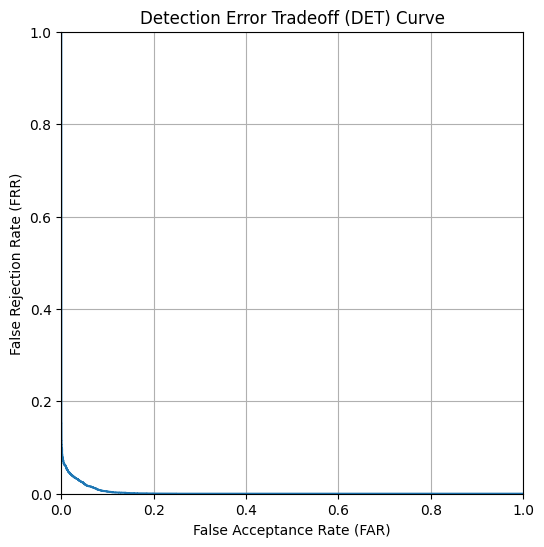


Area Under the ROC Curve (AUC): 0.9971

F1-Score at EER Threshold (0.9242): 0.9683

Additional evaluation metrics calculation complete.


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc, f1_score
import matplotlib.pyplot as plt # Import for plotting

# Ensure similarity_scores and true_labels are available from the main evaluation
if 'similarity_scores' not in locals() or 'true_labels' not in locals():
    raise NameError("Error: 'similarity_scores' or 'true_labels' not found. Please run the evaluation steps first.")

print("Calculating additional evaluation metrics...")

# 1. Calculate DET Curve points (FAR vs FRR)
# roc_curve gives us FPR (FAR) and TPR (1-FRR)
fpr, tpr, thresholds = roc_curve(true_labels, similarity_scores)
far = fpr
frr = 1 - tpr

print("\nDET Curve Points (FAR vs FRR):")
# Print a few points
for i in range(0, len(thresholds), len(thresholds) // 10 + 1): # Print ~10 points
    print(f"  Threshold: {thresholds[i]:.4f}, FAR: {far[i]:.4f}, FRR: {frr[i]:.4f}")


# Plot the DET curve
plt.figure(figsize=(8, 6))
plt.plot(far, frr)
plt.xlabel("False Acceptance Rate (FAR)")
plt.ylabel("False Rejection Rate (FRR)")
plt.title("Detection Error Tradeoff (DET) Curve")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box') # Make axes equal for better visualization
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()


# 2. Calculate Area Under the ROC Curve (AUC)
# roc_curve already provides the points needed for AUC
roc_auc = auc(fpr, tpr)

print(f"\nArea Under the ROC Curve (AUC): {roc_auc:.4f}")

# 3. Calculate F1-Score
# F1-score depends on a specific threshold. We'll calculate it for the EER threshold
if 'eer_threshold' not in locals():
    print("\nWarning: EER threshold not found. Cannot calculate F1-score at EER.")
else:
    # Get predicted labels at the EER threshold
    predicted_labels_at_eer = (similarity_scores >= eer_threshold)

    # Calculate F1-score
    f1 = f1_score(true_labels, predicted_labels_at_eer)

    print(f"\nF1-Score at EER Threshold ({eer_threshold:.4f}): {f1:.4f}")

print("\nAdditional evaluation metrics calculation complete.")

# Validation in other dataset

## Upload new dataset

### Subtask:
Upload the new audio dataset to a specified directory in your Colab environment.


**Reasoning**:
The subtask is to make a new dataset available on the EC2 instance. We'll rely on the same workspace layout and sync the files using AWS tooling (for example, `aws s3 sync`) or scp before preprocessing.


In [ ]:
from pathlib import Path

BASE_DIR = Path(os.environ.get("XOUNDS_WORKSPACE", Path.cwd() / "xounds_workspace")).expanduser()
validation_root = BASE_DIR / "validation_dataset"
new_consent_dir = str((validation_root / "consent_new").resolve())

Path(new_consent_dir).mkdir(parents=True, exist_ok=True)
print(f"Validation dataset directory: {new_consent_dir}")
print(f"Sync or copy your new dataset before continuing (e.g., `aws s3 sync s3://<bucket>/path {new_consent_dir}`).")

existing = sorted(Path(new_consent_dir).glob("*.wav"))
if existing:
    print(f"Detected {len(existing)} .wav files:")
    for item in existing:
        print(f" - {item.name}")
else:
    print("No .wav files detected yet.")


Uploading files to /content/Validation_data_from_different_dataset/consent_new...


Saving female_1_en-AU-NatashaNeural.wav to female_1_en-AU-NatashaNeural.wav
Saving female_2_en-GB-SoniaNeural.wav to female_2_en-GB-SoniaNeural.wav
Saving female_3_en-US-JennyNeural.wav to female_3_en-US-JennyNeural.wav
Saving female_4_en-AU-NatashaNeural.wav to female_4_en-AU-NatashaNeural.wav
Saving female_5_en-GB-SoniaNeural.wav to female_5_en-GB-SoniaNeural.wav
Saving female_6_en-IN-NeerjaNeural.wav to female_6_en-IN-NeerjaNeural.wav
Saving female_7_en-GB-SoniaNeural.wav to female_7_en-GB-SoniaNeural.wav
Saving female_8_en-GB-SoniaNeural.wav to female_8_en-GB-SoniaNeural.wav
Saving female_9_en-IN-NeerjaNeural.wav to female_9_en-IN-NeerjaNeural.wav
Saving female_10_en-GB-SoniaNeural.wav to female_10_en-GB-SoniaNeural.wav
Saving female_11_en-GB-SoniaNeural.wav to female_11_en-GB-SoniaNeural.wav
Saving female_12_en-US-JennyNeural.wav to female_12_en-US-JennyNeural.wav
Saving female_13_en-US-JennyNeural.wav to female_13_en-US-JennyNeural.wav
Saving female_14_en-AU-NatashaNeural.wav to 

## Preprocessing new dataset

In [ ]:
import os
import glob
from pathlib import Path
from tqdm.notebook import tqdm
import torchaudio
import torch
import librosa  # Import librosa for trimming

BASE_DIR = Path(os.environ.get("XOUNDS_WORKSPACE", Path.cwd() / "xounds_workspace")).expanduser()
validation_root = BASE_DIR / "validation_dataset"
new_consent_dir = str((validation_root / "consent_new").resolve())
preprocessed_new_audio_dir = str((validation_root / "preprocessed_new").resolve())

os.makedirs(preprocessed_new_audio_dir, exist_ok=True)

print(f"Starting preprocessing of new audio files from {new_consent_dir}...")

new_audio_files = sorted(glob.glob(os.path.join(new_consent_dir, "*.wav")))

if not new_audio_files:
    print(f"No .wav files found in {new_consent_dir}. Cannot preprocess.")
else:
    print(f"Found {len(new_audio_files)} new audio files to preprocess.")

    def preprocess_audio(input_filepath, output_filepath, target_sr=16000):
        """
        Resamples, normalizes, and trims silence from an audio file.

        Args:
            input_filepath (str): Path to the input audio file.
            output_filepath (str): Path to save the processed audio file.
            target_sr (int): Target sampling rate.
        """
        try:
            waveform, sample_rate = torchaudio.load(input_filepath)

            if sample_rate != target_sr:
                resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sr)
                waveform = resampler(waveform)
                sample_rate = target_sr

            waveform_np = waveform.squeeze().numpy()

            trimmed_waveform_np, index = librosa.effects.trim(waveform_np)

            if trimmed_waveform_np.size == 0:
                print(f"Warning: Audio file {input_filepath} was entirely silence and removed after trimming.")
                return

            waveform = torch.tensor(trimmed_waveform_np).unsqueeze(0)

            if torch.max(torch.abs(waveform)) > 0:
                waveform = waveform / torch.max(torch.abs(waveform))
            else:
                print(f"Warning: Audio file {input_filepath} seems to be all silence after trimming.")

            torchaudio.save(output_filepath, waveform, sample_rate)

        except Exception as e:
            print(f"Error processing {input_filepath}: {e}")

    for input_filepath in tqdm(new_audio_files, desc="Preprocessing New Audio"):
        filename = os.path.basename(input_filepath)
        output_filepath = os.path.join(preprocessed_new_audio_dir, filename)
        preprocess_audio(input_filepath, output_filepath)

    print("
Preprocessing of new audio files complete.")

preprocessed_files_check = sorted(glob.glob(os.path.join(preprocessed_new_audio_dir, "*.wav")))
print(f"Found {len(preprocessed_files_check)} preprocessed files in {preprocessed_new_audio_dir}.")


Starting preprocessing of new audio files from /content/Validation_data_from_different_dataset/consent_new...
Found 100 new audio files to preprocess.


Preprocessing New Audio:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r


Preprocessing of new audio files complete.
Found 100 preprocessed files in /content/Validation_data_from_different_dataset/preprocessed_new.


In [ ]:
import torchaudio
import os
import glob
import torch
from tqdm.notebook import tqdm
import pickle
import torch.nn.functional as F
from pathlib import Path

BASE_DIR = Path(os.environ.get("XOUNDS_WORKSPACE", Path.cwd() / "xounds_workspace")).expanduser()
validation_root = BASE_DIR / "validation_dataset"
preprocessed_new_audio_dir = str((validation_root / "preprocessed_new").resolve())
embeddings_new_output_dir = str((validation_root / "embeddings_new").resolve())

os.makedirs(preprocessed_new_audio_dir, exist_ok=True)
os.makedirs(embeddings_new_output_dir, exist_ok=True)

new_audio_embeddings = {}

if 'verification' not in locals() or verification is None:
    raise NameError("Error: 'verification' model is not loaded. Please run the model loading cell first.")

device = next(verification.parameters()).device
verification.eval()

def load_mono_16k(path, target_sr=16000):
    wav, sr = torchaudio.load(path)
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    if sr != target_sr:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=target_sr)
        wav = resampler(wav)
    return wav.squeeze(0)

new_files = sorted(glob.glob(os.path.join(preprocessed_new_audio_dir, "*.wav")))
if not new_files:
    raise FileNotFoundError(f"No .wav found in {preprocessed_new_audio_dir}. Did you run the preprocessing for the new dataset?")

print(f"Found {len(new_files)} new files. Extracting embeddings with the fine-tuned model...")

for f in tqdm(new_files, desc="Embedding New Audio"):
    try:
        wav_1d = load_mono_16k(f)
        wav_bt = wav_1d.unsqueeze(0).to(device)

        with torch.no_grad():
            emb = verification.encode_batch(wav_bt)

        new_audio_embeddings[os.path.basename(f)] = emb.squeeze(0).cpu().numpy()
    except Exception as e:
        print(f"
Error extracting embeddings for {os.path.basename(f)}: {e}")

print("
Done. Got embeddings for", len(new_audio_embeddings), "new files.")

new_embeddings_filename = "new_audio_embeddings.pkl"
new_embeddings_filepath = os.path.join(embeddings_new_output_dir, new_embeddings_filename)
try:
    with open(new_embeddings_filepath, "wb") as f:
        pickle.dump(new_audio_embeddings, f)
    print(f"New embeddings saved to: {new_embeddings_filepath}")
except Exception as e:
    print(f"Error saving new embeddings: {e}")


Found 100 new files. Extracting embeddings with the fine-tuned model…


Embedding New Audio:   0%|          | 0/100 [00:00<?, ?it/s]


Done. Got embeddings for 100 new files.
New embeddings saved to: /content/Validation_data_from_different_dataset/embeddings_new/new_audio_embeddings.pkl


## Prepare evaluation pairs for new dataset

### Subtask:
Create pairs of audio files (positive for same speaker, negative for different speakers) and their corresponding labels from the new dataset's embeddings.

**Reasoning**:
To evaluate the speaker verification model, I need to create pairs of audio files from the new dataset and label them as either same-speaker (positive) or different-speaker (negative. This will allow me to compute similarity scores and assess the model's ability to distinguish between speakers.

In [ ]:
import os
import glob
import random

# Ensure new_audio_embeddings dictionary is available
if 'new_audio_embeddings' not in locals() or not new_audio_embeddings:
    raise NameError("Error: 'new_audio_embeddings' dictionary not found or is empty. Please run the embedding extraction step for the new dataset.")

# Get the list of filenames from the extracted embeddings
new_dataset_filenames = list(new_audio_embeddings.keys())

# Initialize lists for positive and negative pairs from the new dataset
new_positive_pairs = []
new_negative_pairs = []

print(f"Creating evaluation pairs for the new dataset with {len(new_dataset_filenames)} files...")

# Iterate through files to create pairs
for i in range(len(new_dataset_filenames)):
    file1_name = new_dataset_filenames[i]
    # Assuming speaker label is before the first underscore
    speaker1_label = file1_name.split('_')[0]

    for j in range(i + 1, len(new_dataset_filenames)):
        file2_name = new_dataset_filenames[j]
        speaker2_label = file2_name.split('_')[0]

        if speaker1_label == speaker2_label:
            new_positive_pairs.append((file1_name, file2_name))
        else:
            new_negative_pairs.append((file1_name, file2_name))

# Optionally, limit the number of negative pairs for balancing
# This is a simple approach; more sophisticated methods exist.
if len(new_negative_pairs) > len(new_positive_pairs) * 2: # Example: keep at most twice the number of positive pairs
    new_negative_pairs = random.sample(new_negative_pairs, len(new_positive_pairs) * 2)

# Print the number of positive and negative pairs for the new dataset
print(f"\nCreated {len(new_positive_pairs)} positive pairs for the new dataset.")
print(f"Created {len(new_negative_pairs)} negative pairs for the new dataset.")

# These lists (new_positive_pairs and new_negative_pairs) will be used in the next step
# to compute similarity scores.

Creating evaluation pairs for the new dataset with 100 files...

Created 2450 positive pairs for the new dataset.
Created 2500 negative pairs for the new dataset.


## Compute similarity scores for new dataset

### Subtask:
Calculate the similarity scores between the pairs of embeddings from the new dataset.

**Reasoning**:
To evaluate the model's performance, I need to calculate the similarity between the embeddings of each pair. I will use cosine similarity for this purpose, which is a common metric for comparing embeddings.

In [ ]:
import os
import itertools
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm.notebook import tqdm

# Ensure new_audio_embeddings, new_positive_pairs, and new_negative_pairs are available
if 'new_audio_embeddings' not in locals() or not new_audio_embeddings:
    raise NameError("Error: 'new_audio_embeddings' dictionary not found or is empty. Please run the embedding extraction step for the new dataset.")
if 'new_positive_pairs' not in locals() or 'new_negative_pairs' not in locals():
     raise NameError("Error: 'new_positive_pairs' or 'new_negative_pairs' not found. Please run the data preparation step for the new dataset.")

# Combine positive and negative pairs
all_new_pairs = new_positive_pairs + new_negative_pairs
new_true_labels = [1] * len(new_positive_pairs) + [0] * len(new_negative_pairs)

# Initialize list to store similarity scores
new_similarity_scores = []

print(f"Computing similarity scores for {len(all_new_pairs)} pairs in the new dataset...")

# Compute similarity scores for each pair
for filename1, filename2 in tqdm(all_new_pairs, desc="Computing New Similarity Scores"):
    try:
        # Get the embeddings for the two files
        embedding1 = new_audio_embeddings[filename1]
        embedding2 = new_audio_embeddings[filename2]

        # Reshape embeddings for cosine_similarity (needs shape [1, n_features])
        embedding1 = embedding1.reshape(1, -1)
        embedding2 = embedding2.reshape(1, -1)

        # Compute cosine similarity
        similarity = cosine_similarity(embedding1, embedding2)[0][0]

        # Store the similarity score
        new_similarity_scores.append(similarity)

    except Exception as e:
        print(f"\nError processing pair ({filename1}, {filename2}): {e}")

print("\nSimilarity score computation for new dataset complete.")
print(f"Computed scores for {len(new_similarity_scores)} pairs.")

# Convert lists to numpy arrays for easier processing in the next step
new_similarity_scores = np.array(new_similarity_scores)
new_true_labels = np.array(new_true_labels)


# Print a few examples
print("\nExample pairs and their scores from the new dataset:")
# It's harder to show filenames directly here without the original pair list structure,
# but we can show scores and labels.
for i in range(min(5, len(new_similarity_scores))):
    print(f"Pair {i+1}: Score = {new_similarity_scores[i]:.4f}, True Label = {new_true_labels[i]}")

Computing similarity scores for 4950 pairs in the new dataset...


Computing New Similarity Scores:   0%|          | 0/4950 [00:00<?, ?it/s]


Similarity score computation for new dataset complete.
Computed scores for 4950 pairs.

Example pairs and their scores from the new dataset:
Pair 1: Score = 1.0000, True Label = 1
Pair 2: Score = 0.9612, True Label = 1
Pair 3: Score = 0.9617, True Label = 1
Pair 4: Score = 0.9820, True Label = 1
Pair 5: Score = 1.0000, True Label = 1


## Calculate EER for new dataset

### Subtask:
Calculate the Equal Error Rate (EER) using the similarity scores and true labels from the new dataset to evaluate the model's performance.

**Reasoning**:
The Equal Error Rate (EER) is a common metric for evaluating speaker verification systems. It represents the point where the False Acceptance Rate (FAR) and False Rejection Rate (FRR) are equal. Calculating the EER for the new dataset will provide a single metric to compare the model's performance on this data compared to the original evaluation set.

In [ ]:
import numpy as np
from scipy.optimize import brentq
from sklearn.metrics import roc_curve

# Ensure new_similarity_scores and new_true_labels are available
if 'new_similarity_scores' not in locals() or 'new_true_labels' not in locals():
    raise NameError("Error: 'new_similarity_scores' or 'new_true_labels' not found. Please run the previous steps to compute them.")

# Function to calculate EER by minimizing |FAR - FRR|
def calculate_eer(similarity_scores, true_labels):
    """
    Calculates the Equal Error Rate (EER) by finding the threshold where FAR and FRR are closest.

    Args:
        similarity_scores (np.array): Array of similarity scores.
        true_labels (np.array): Array of true labels (1 for same speaker, 0 for different).

    Returns:
        tuple: (EER value, EER threshold)
    """
    # Compute ROC curve points (fpr, tpr, thresholds)
    fpr, tpr, thresholds = roc_curve(true_labels, similarity_scores)

    # Calculate FRR (1 - tpr)
    frr = 1 - tpr

    # Find the index where the absolute difference between FAR and FRR is minimized
    eer_threshold_index = np.nanargmin(np.abs(fpr - frr))

    # Get the EER value and threshold at this index
    eer_value = fpr[eer_threshold_index]
    eer_threshold = thresholds[eer_threshold_index]

    return eer_value, eer_threshold


print("Calculating EER for the new dataset:")

# Calculate EER and the corresponding threshold for the new dataset
new_eer_value, new_eer_threshold = calculate_eer(new_similarity_scores, new_true_labels)

print(f"\nEqual Error Rate (EER) for the new dataset: {new_eer_value:.4f}")
print(f"EER Threshold for the new dataset: {new_eer_threshold:.4f}")

Calculating EER for the new dataset:

Equal Error Rate (EER) for the new dataset: 0.0200
EER Threshold for the new dataset: 0.9415


**Reasoning**:
Update the markdown content in the "Quick overview" cell to summarize the project.

